<a href="https://colab.research.google.com/github/EstebanPiacentino/GAN4DataAnonymization/blob/master/GAN_with_PyTorch_Cardio_Data_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd /gdrive/My Drive/Colab Notebooks

/gdrive/My Drive/Colab Notebooks


In [0]:
#Dependencies
import numpy as np
import pandas as pd
import os
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from random import choice
import ast

from zipfile import ZipFile
import io as ios

In [0]:
class CardioDataset(Dataset):
    """Fingerprints dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = pd.read_csv(self.root_dir, index_col=0)

    def __len__(self):
      return 28902 #Total number of images

    def __getitem__(self, idx):
        sample=ast.literal_eval(self.archive.loc[idx,'signal'])[:2025]
        #sample=[self.remap(x,sample) for x in sample]
        sample=np.reshape(sample,(45,45))
        sample_bloc=np.uint8(sample)
        image = sample_bloc 

        if self.transform:
            image = self.transform(image)

        return image
    
    def remap(self,x,sample):
        A=min(sample)
        B=max(sample)
        C=0
        D=255
        
        out=(x-A)/(B-A)*(D-C)+C
        return int(out)

In [0]:
#Load
out_dir = './Iris_dataset' #saves dataset here
transform =  transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))])
#download MNIST, save and apply transform 
cardio_data =  CardioDataset(root_dir='output_cardio_db_remapped.csv', transform=transform)
#Data loader feeds data as inputs and labels, of fixed batch size
train_loader = torch.utils.data.DataLoader(cardio_data, batch_size = 30, shuffle = True)


In [0]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
#Define discriminator
def disc_model():
    discriminator_model = nn.Sequential(
      nn.Conv2d(1, 64, 6, 1, 1, bias=False),
      nn.LeakyReLU(.2, inplace=True),
      nn.Conv2d(64, 128, 6, 2, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(.2, inplace=True),
      nn.Conv2d(128, 256, 6, 2, 1, bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(.2, inplace=True),
      nn.Conv2d(256, 1, 6, 3, 0, bias=False),
      nn.AdaptiveAvgPool2d(1),
        
      nn.Sigmoid()
      ).to(device)
    return discriminator_model
#create a discriminator network
discriminator = disc_model()
#if we want to start from a checkpoint model
discriminator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['dis_state_dict'])
discriminator.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Conv2d(128, 256, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace)
  (8): Conv2d(256, 1, kernel_size=(6, 6), stride=(3, 3), bias=False)
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Sigmoid()
)

In [0]:
#Define generator
def gen_model():
    generator_model = nn.Sequential(
       nn.ConvTranspose2d(100, 256, 8, 2, 0, bias=False),
       nn.BatchNorm2d(256),
       nn.ReLU(True),
       nn.ConvTranspose2d(256, 128, 7, 2, 1, bias=False),
       nn.BatchNorm2d(128),
       nn.ReLU(True),
       nn.ConvTranspose2d(128, 64, 7, 2, 1, bias=False),
       nn.BatchNorm2d(64),
       nn.ReLU(True),
       nn.ConvTranspose2d(64, 1, 7, 1, 1, bias=False),
       
       nn.Tanh()    
       ).to(device)
    return generator_model
#create a generator network
generator = gen_model()
#if we want to start from a checkpoint model
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

Sequential(
  (0): ConvTranspose2d(100, 256, kernel_size=(8, 8), stride=(2, 2), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): ConvTranspose2d(256, 128, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace)
  (9): ConvTranspose2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [0]:
#Noise generator
from torch.autograd import Variable
def rand_vecs(batch_size):
    return Variable(torch.randn(batch_size, 100)).to(device)

In [0]:
#Define optimizer and loss criterion
import torch.optim as optim
#create separate optimizers, use BCELoss for both networks
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
criterion = nn.BCELoss()

In [0]:
#Get the labels
def ones_or_zeros(batch_size, labels):
    if labels == 1:
        return Variable(torch.ones(batch_size, 1)).to(device)
    elif labels == 0:
        return Variable(torch.zeros(batch_size, 1)).to(device)

torch.Size([1, 45, 45])


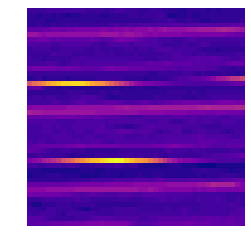

In [0]:
#Check ground truth sample:
for inputs in train_loader:
  print(inputs[0].shape)
  sample=inputs[0].view(-1, 45).detach().numpy()
  plt.axis('off')
  plt.grid(b=None)
  im=plt.imshow(sample)
  im.set_cmap('plasma')
  break

 100.0% Epoch passed
New epoch: 37
 100.0% Epoch passed
New epoch: 38
 100.0% Epoch passed
New epoch: 39
 100.0% Epoch passed
New epoch: 40
 100.0% Epoch passedloss_disc:0.0219776.., loss_generator: 7.8728


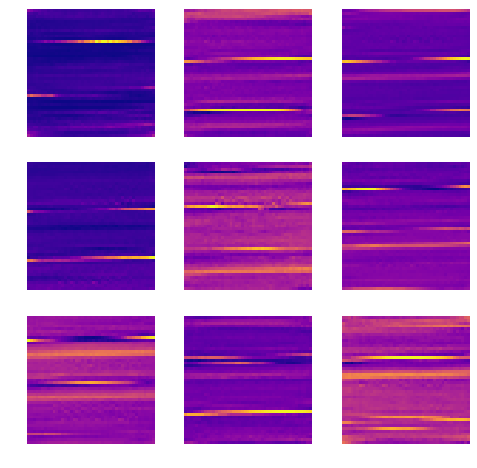

 100.0% Epoch passed
New epoch: 42
 100.0% Epoch passed
New epoch: 43
 100.0% Epoch passed
New epoch: 44
 100.0% Epoch passed
New epoch: 45
 100.0% Epoch passedloss_disc:0.0125534.., loss_generator: 7.0466


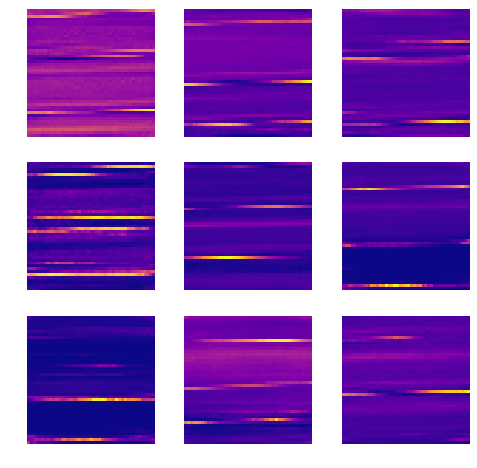

 100.0% Epoch passed
New epoch: 47
 100.0% Epoch passed
New epoch: 48
 100.0% Epoch passed
New epoch: 49
 100.0% Epoch passed
New epoch: 50
 100.0% Epoch passedloss_disc:0.142939.., loss_generator: 4.74


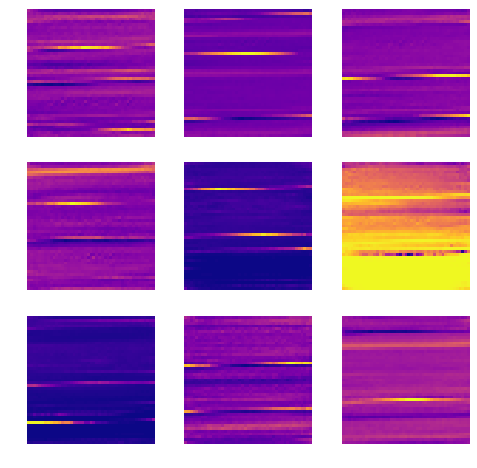

 100.0% Epoch passed
New epoch: 52
 100.0% Epoch passed
New epoch: 53
 100.0% Epoch passed
New epoch: 54
 100.0% Epoch passed
New epoch: 55
 100.0% Epoch passedloss_disc:0.101241.., loss_generator: 5.9888


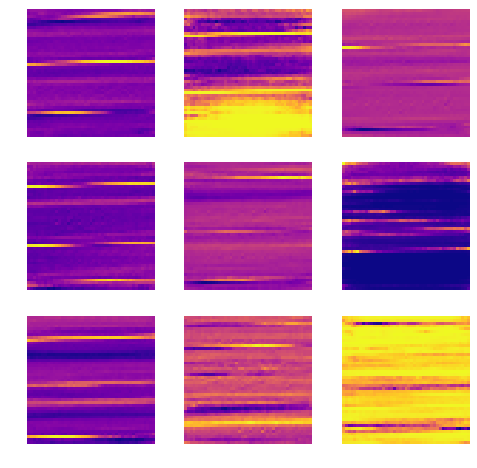

 100.0% Epoch passed
New epoch: 57
 100.0% Epoch passed
New epoch: 58
 100.0% Epoch passed
New epoch: 59
 100.0% Epoch passed
New epoch: 60
 100.0% Epoch passedloss_disc:0.00587802.., loss_generator: 5.7127


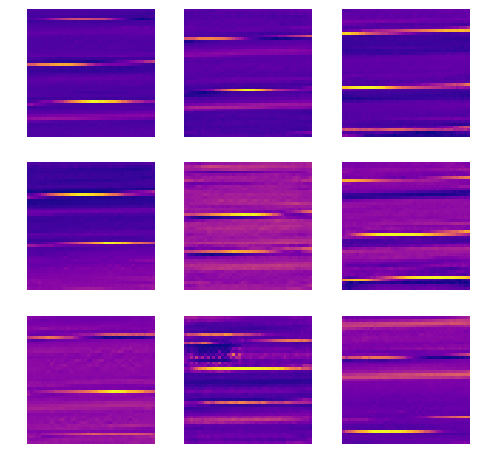

 100.0% Epoch passed
New epoch: 62
 100.0% Epoch passed
New epoch: 63
 100.0% Epoch passed
New epoch: 64
 100.0% Epoch passed
New epoch: 65
 100.0% Epoch passedloss_disc:0.1987.., loss_generator: 3.675


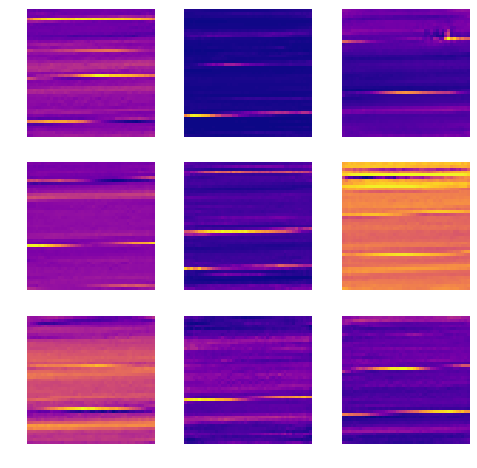

 100.0% Epoch passed
New epoch: 67
 100.0% Epoch passed
New epoch: 68
 100.0% Epoch passed
New epoch: 69
 100.0% Epoch passed
New epoch: 70
 100.0% Epoch passedloss_disc:0.0564598.., loss_generator: 11.117


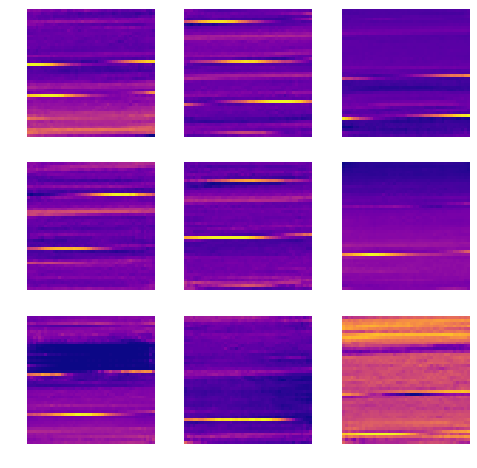

 100.0% Epoch passed
New epoch: 72
 100.0% Epoch passed
New epoch: 73
 100.0% Epoch passed
New epoch: 74
 100.0% Epoch passed
New epoch: 75
 100.0% Epoch passedloss_disc:0.0703047.., loss_generator: 10.196


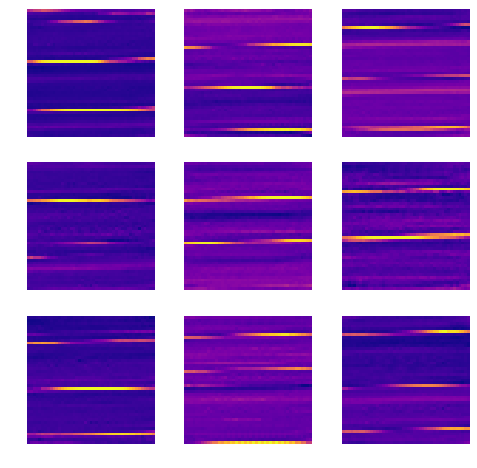

 100.0% Epoch passed
New epoch: 77
 100.0% Epoch passed
New epoch: 78
 100.0% Epoch passed
New epoch: 79
 100.0% Epoch passed
New epoch: 80
 100.0% Epoch passedloss_disc:0.872477.., loss_generator: 2.2481


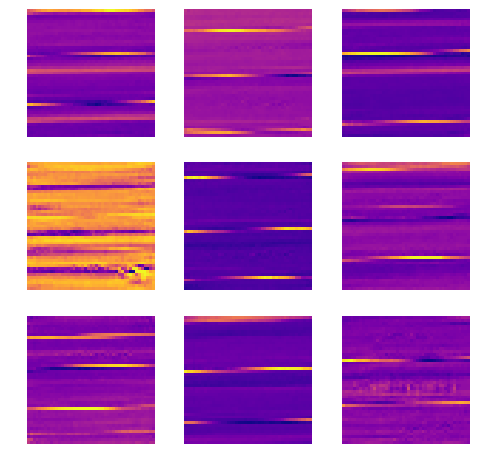

 100.0% Epoch passed
New epoch: 82
 100.0% Epoch passed
New epoch: 83
 100.0% Epoch passed
New epoch: 84
 100.0% Epoch passed
New epoch: 85
 100.0% Epoch passedloss_disc:0.00427816.., loss_generator: 6.0728


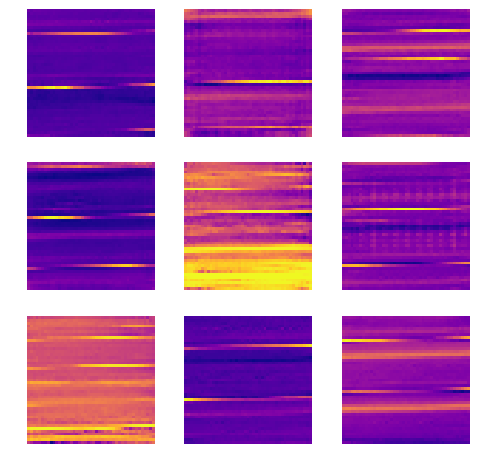

 100.0% Epoch passed
New epoch: 87
 100.0% Epoch passed
New epoch: 88
 100.0% Epoch passed
New epoch: 89
 100.0% Epoch passed
New epoch: 90
 100.0% Epoch passedloss_disc:0.032274.., loss_generator: 5.5864


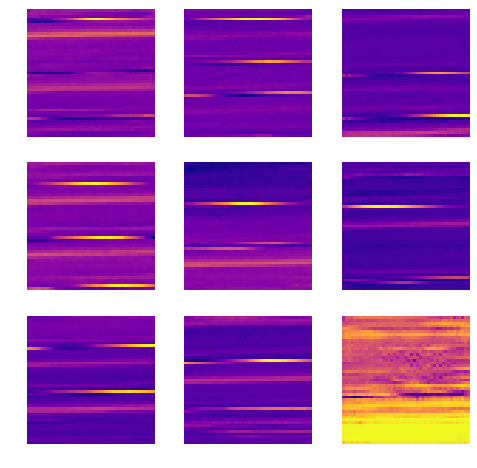

 100.0% Epoch passed
New epoch: 92
 100.0% Epoch passed
New epoch: 93
 100.0% Epoch passed
New epoch: 94
 100.0% Epoch passed
New epoch: 95
 100.0% Epoch passedloss_disc:0.235108.., loss_generator: 4.8794


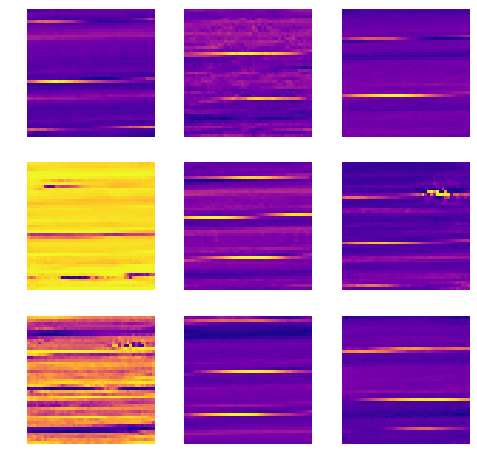

 100.0% Epoch passed
New epoch: 97
 100.0% Epoch passed
New epoch: 98
 100.0% Epoch passed
New epoch: 99
 100.0% Epoch passed
New epoch: 100
 100.0% Epoch passedloss_disc:0.00955179.., loss_generator: 3.5182


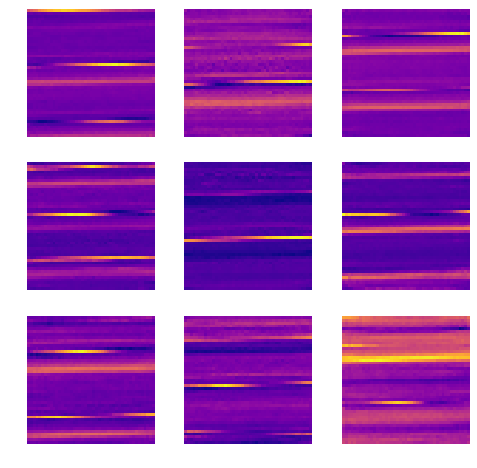

 100.0% Epoch passed
New epoch: 102
 100.0% Epoch passed
New epoch: 103
 100.0% Epoch passed
New epoch: 104
 100.0% Epoch passed
New epoch: 105
 100.0% Epoch passedloss_disc:0.0202483.., loss_generator: 6.5112


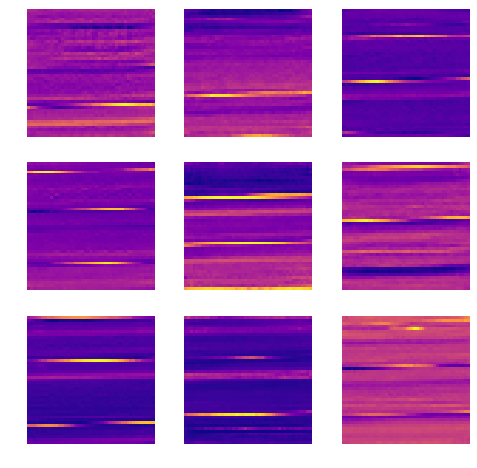

 100.0% Epoch passed
New epoch: 107
 100.0% Epoch passed
New epoch: 108
 100.0% Epoch passed
New epoch: 109
 100.0% Epoch passed
New epoch: 110
 100.0% Epoch passedloss_disc:0.589032.., loss_generator: 8.8566


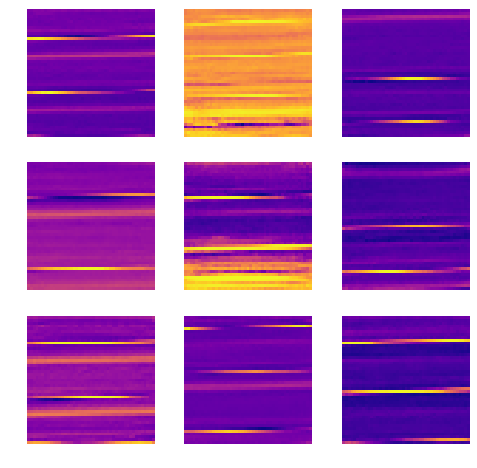

 100.0% Epoch passed
New epoch: 112
 100.0% Epoch passed
New epoch: 113
 100.0% Epoch passed
New epoch: 114
 100.0% Epoch passed
New epoch: 115
 100.0% Epoch passedloss_disc:0.124131.., loss_generator: 4.3767


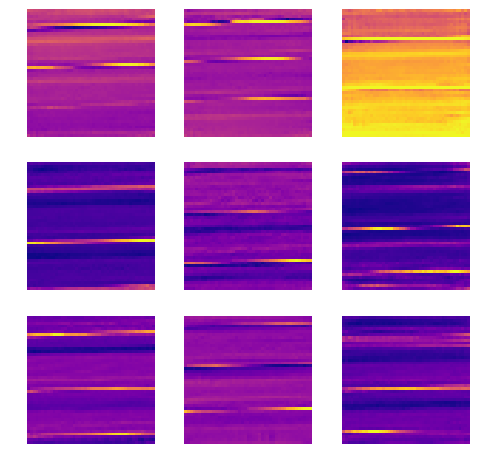

 100.0% Epoch passed
New epoch: 117
 100.0% Epoch passed
New epoch: 118
 100.0% Epoch passed
New epoch: 119
 100.0% Epoch passed
New epoch: 120
 100.0% Epoch passedloss_disc:0.136749.., loss_generator: 8.016


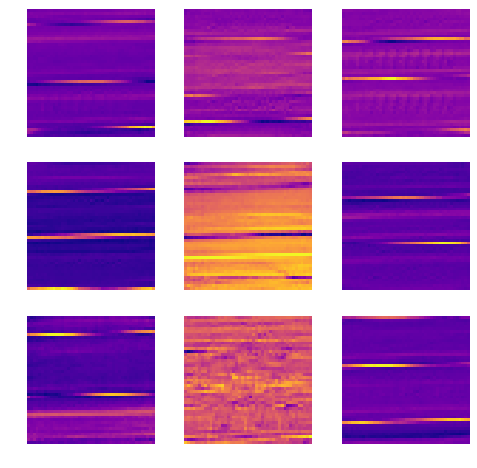

 100.0% Epoch passed
New epoch: 122
 100.0% Epoch passed
New epoch: 123
 100.0% Epoch passed
New epoch: 124
 100.0% Epoch passed
New epoch: 125
 100.0% Epoch passedloss_disc:2.18576.., loss_generator: 3.0108


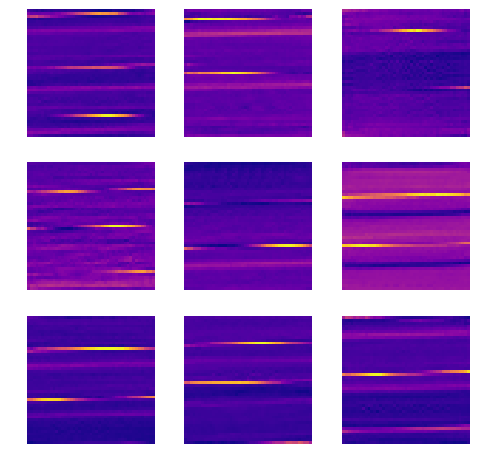

 100.0% Epoch passed
New epoch: 127
 100.0% Epoch passed
New epoch: 128
 100.0% Epoch passed
New epoch: 129
 100.0% Epoch passed
New epoch: 130
 100.0% Epoch passedloss_disc:0.0236222.., loss_generator: 4.3107


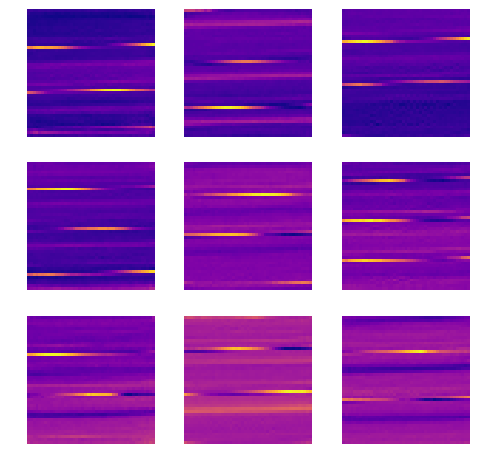

 100.0% Epoch passed
New epoch: 132
 100.0% Epoch passed
New epoch: 133
 100.0% Epoch passed
New epoch: 134
 100.0% Epoch passed
New epoch: 135
 100.0% Epoch passedloss_disc:0.216835.., loss_generator: 4.3044


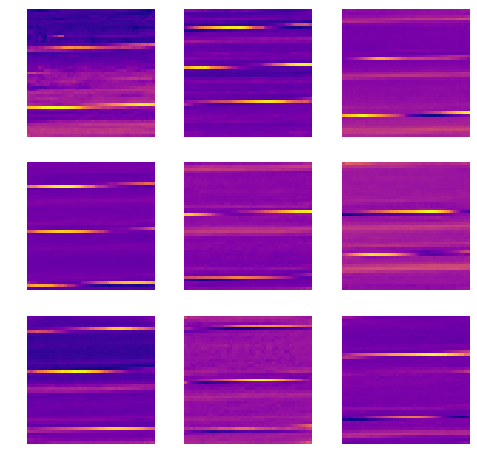

 100.0% Epoch passed
New epoch: 137
 100.0% Epoch passed
New epoch: 138
 100.0% Epoch passed
New epoch: 139
 100.0% Epoch passed
New epoch: 140
 100.0% Epoch passedloss_disc:0.151283.., loss_generator: 2.9445


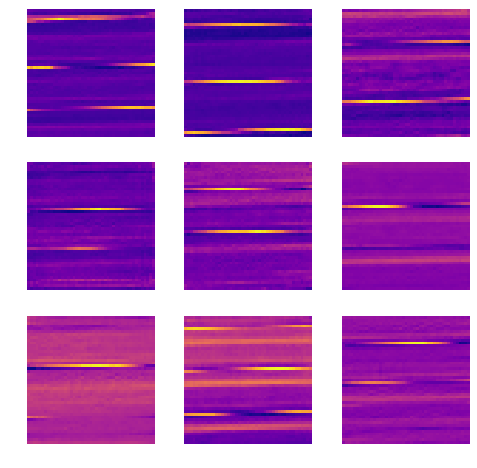

 100.0% Epoch passed
New epoch: 142
 100.0% Epoch passed
New epoch: 143
 100.0% Epoch passed
New epoch: 144
 100.0% Epoch passed
New epoch: 145
 100.0% Epoch passedloss_disc:0.0300158.., loss_generator: 1.5071


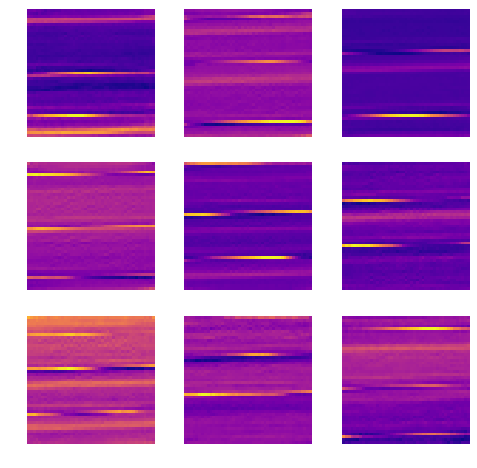

 100.0% Epoch passed
New epoch: 147
 100.0% Epoch passed
New epoch: 148
 100.0% Epoch passed
New epoch: 149
 100.0% Epoch passed
New epoch: 150
 100.0% Epoch passedloss_disc:0.00943672.., loss_generator: 1.9388


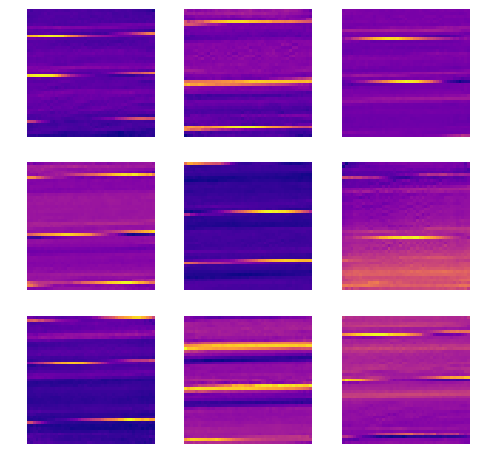

 100.0% Epoch passed
New epoch: 152
 100.0% Epoch passed
New epoch: 153
 100.0% Epoch passed
New epoch: 154
 100.0% Epoch passed
New epoch: 155
 100.0% Epoch passedloss_disc:0.182835.., loss_generator: 1.2797


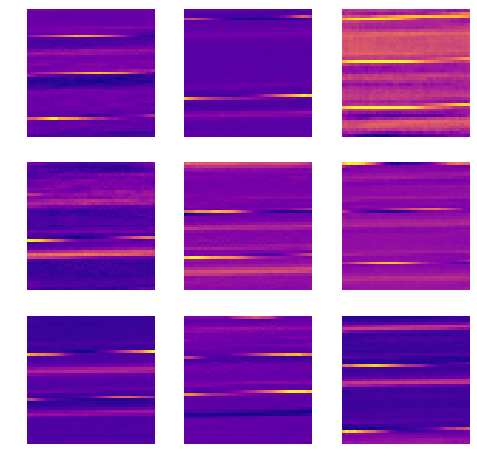

 100.0% Epoch passed
New epoch: 157
 100.0% Epoch passed
New epoch: 158
 100.0% Epoch passed
New epoch: 159
 100.0% Epoch passed
New epoch: 160
 100.0% Epoch passedloss_disc:0.0237371.., loss_generator: 2.3976


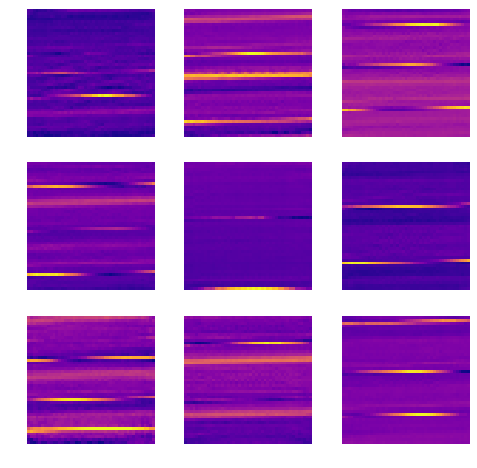

 100.0% Epoch passed
New epoch: 162
 100.0% Epoch passed
New epoch: 163
 100.0% Epoch passed
New epoch: 164
 100.0% Epoch passed
New epoch: 165
 100.0% Epoch passedloss_disc:0.0655522.., loss_generator: 4.6231


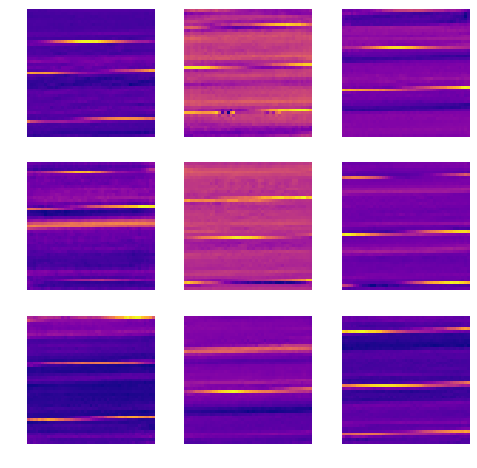

 100.0% Epoch passed
New epoch: 167
 100.0% Epoch passed
New epoch: 168
 100.0% Epoch passed
New epoch: 169
 100.0% Epoch passed
New epoch: 170
 100.0% Epoch passedloss_disc:0.809011.., loss_generator: 4.8035


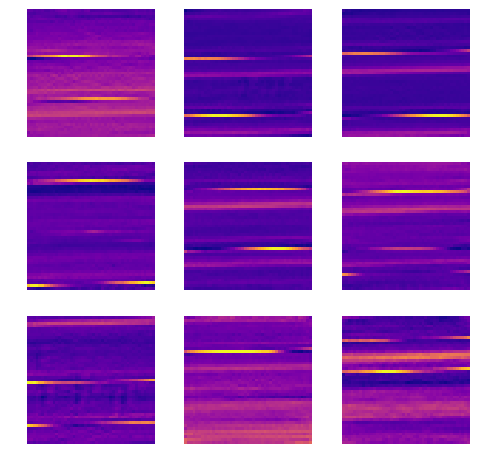

 100.0% Epoch passed
New epoch: 172
 100.0% Epoch passed
New epoch: 173
 100.0% Epoch passed
New epoch: 174
 100.0% Epoch passed
New epoch: 175
 58.4% Epoch passedBuffered data was truncated after reaching the output size limit.

In [0]:
#TRAIN
#Create empty lists to catch losses
losses_disc, losses_generator = [], []
print_freq = 5 #fix how frequently to print losses
for epoch in range(36,201): #100 by default
    #Networks are training hence, .train()
    discriminator.train()
    generator.train()
    
#Train discriminator
    tot_inputs_passed=0
    for inputs in train_loader:
        
        #.to(device)--> work in either cpu or gpu     
        inputs = inputs.to(device) 
        
        batch_size = inputs.size(0)
        #Note: inputs.shape ->([52, 1, 28, 28])        
        #reshape to (batch_size, features) as expected by network
        #real_data = inputs.view(inputs.size(0), -1) 
        
        #Flush the retained gradients
        d_optimizer.zero_grad()
        # probabilities given real data
        
        pred_real = discriminator(inputs) 
        
        pred_real_re = pred_real.view(inputs.size(0), -1)
        #Computing loss for real data         
        loss_real=criterion(pred_real_re, ones_or_zeros(batch_size, 1))
        
        #Note grads for gen are detached
        fake_data = generator(rand_vecs(batch_size).view(batch_size,100,1,1)).detach()
 
        fake_data = fake_data.to(device)
        # probabilities given fake data
        pred_fake = discriminator(fake_data) 
        
        pred_fake_re = pred_fake.view(inputs.size(0), -1)
        #Computing loss for generated data
        loss_fake=criterion(pred_fake_re, ones_or_zeros(batch_size, 0))
        
        loss_disc = loss_real + loss_fake  #combined loss
        losses_disc.append(loss_disc.item()) # log the losses
        if loss_disc.item() >= 0.01:
          #computes the gradients        
          loss_disc.backward()
          #update parameters using gradients & optimizer rules       
          d_optimizer.step()
        else:
          pass
 
        #discriminator completes a loop
#Train generator
        #Trains from scratch, newly generated data are used
        g_optimizer.zero_grad()
        #generates image/feature vector
        fake_data_new = generator(rand_vecs(batch_size).view(batch_size,100,1,1))  
               
        fake_data_new = fake_data_new.to(device)
        
        pred_fake_new = discriminator(fake_data_new)
        
        pred_fake_new_re = pred_fake_new.view(inputs.size(0), -1)
        #Generator's loss minimized after, labels are set to 1 
        loss_generator = criterion(pred_fake_new_re, ones_or_zeros(batch_size, 1))
 
        losses_generator.append(loss_generator.item())
        #computes the gradients 
        loss_generator.backward()
        
        g_optimizer.step() #completes training loop for generator
            
        tot_inputs_passed+=1       
        
        print('\r',str(round(float(tot_inputs_passed)/len(train_loader)*100,2))+"% Epoch passed",end='')
        
#Print and save epoch, generator_state_dict as chk_point
    if epoch % print_freq ==0:
        print("loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator))
        torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'dis_state_dict': discriminator.state_dict(),
            }, ('DataOutput/f_name_RawData' + '.pth'))
        torch.save({
            'epoch': epoch,
            'losses': "loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator),
            }, ('DataOutput/f_name_' + str(epoch) + '.txt'))
        fig=plt.figure(figsize=(8, 8))
        columns = 3
        rows = 3
        for i in range(1, columns*rows +1):
            image=generator(rand_vecs(batch_size).view(batch_size,100,1,1))[choice(range(batch_size))]
            image_host=image.cpu()
            sample=image_host.view(-1, 45).detach().numpy()
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.grid(b=None)
            im=plt.imshow(sample)
            im.set_cmap('plasma')
            plt.imsave('DataOutput/Epoch_'+str(epoch)+'_sample_'+str(i)+'.png', sample, cmap='plasma')
        plt.show()
    else:
        print("\nNew epoch: "+str(epoch+1))

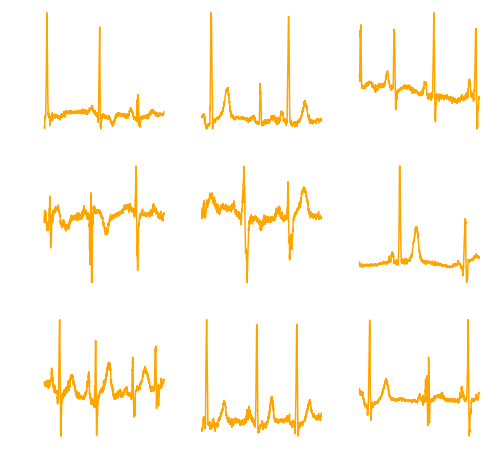

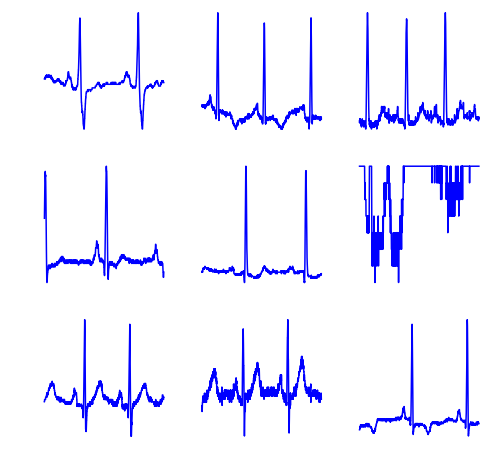

In [0]:
#Loading Images
batch=30

generator=gen_model()
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    image=generator(rand_vecs(batch).view(batch,100,1,1))[choice(range(batch))]
    image_host=image.cpu()
    sample=image_host.view(-1).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(b=None)
    plt.plot(sample, color='orange')
    #im=plt.imshow(sample)
    #im.set_cmap('plasma')
    #plt.imsave('Final_Result_'+str(i)+'.png', sample, cmap='plasma')
plt.show()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    for input in train_loader:
      data=input
      break
    image=data[choice(range(batch))]
    image_host=image.cpu()
    sample=image_host.view(-1).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(b=None)
    plt.plot(sample, color='blue')
    #im=plt.imshow(sample)
    #im.set_cmap('plasma')
    #plt.imsave('Final_Result_'+str(i)+'.png', sample, cmap='plasma')
plt.show()